* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

X = train_df.drop(['label'], axis=1).values.reshape(-1, 28,28) / 255
y = train_df['label'].values

X_test = test_df.values.reshape(-1, 28,28) / 255

Using TensorFlow backend.


In [2]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=10, output_dim=10)(label_input)
x = Reshape((10,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7,7,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        100         label_input[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 10)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
latent_input (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
concatenat

In [3]:
img_input = Input(shape=(28,28,))
x = Reshape((28,28,1))(img_input)
x = Conv2D(16, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(11, activation='softmax')(x)
discriminator = Model(inputs=img_input, outputs=x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 32)          0         
__________

In [4]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = generator([latent_input, label_input])
x = discriminator(x)
gan = Model(inputs=[latent_input, label_input], outputs=x)
discriminator.trainable = False
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_input (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28)       789221      latent_input[0][0]               
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
model_2 (Model)                 (None, 11)           103755      model_1[1][0]                    
Total para

In [5]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.0003))

In [6]:
def random_mnist_set(X, y, size=10):
    length = len(X)
    indices = np.random.choice(length, size)
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    latents = np.random.normal(0, 1, (size, 100))
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(10, size=size)})

In [7]:
save_interval = 300
epochs = save_interval*10+1
batch_size=20
history = {'dloss':[], 'gloss':[]}
for iteration in range(epochs):
    discriminator.trainable=True
    X_sample, y_sample = random_mnist_set(X, y, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    dloss_fake = discriminator.train_on_batch(random_generated_set(generator, size=batch_size), np.full(batch_size, 10))
    
    discriminator.trainable=False
    
    gan_labels = np.random.randint(10, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),
                        'label_input':gan_labels}, 
                       gan_labels)
    
    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    if iteration % save_interval == 0:
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        generator.save_weights('generator_{0:05d}.h5'.format(iteration))

generator: loss=2.829733371734619. acc=0.10000000149011612
discriminator: loss_real=3.0942676067352295, acc_real=0.10000000149011612
    loss_fake=4.789618492126465, acc_fake=0.0
generator: loss=10.819186210632324. acc=0.0
discriminator: loss_real=0.917877197265625, acc_real=0.800000011920929
    loss_fake=0.3770124316215515, acc_fake=0.8999999761581421
generator: loss=4.911131858825684. acc=0.10000000149011612
discriminator: loss_real=0.5357590913772583, acc_real=0.800000011920929
    loss_fake=0.25223103165626526, acc_fake=0.8999999761581421
generator: loss=6.507279396057129. acc=0.0
discriminator: loss_real=0.07876821607351303, acc_real=1.0
    loss_fake=0.09889031201601028, acc_fake=0.949999988079071
generator: loss=3.6601054668426514. acc=0.10000000149011612
discriminator: loss_real=0.10784786939620972, acc_real=1.0
    loss_fake=0.2869240641593933, acc_fake=0.8500000238418579
generator: loss=4.330793857574463. acc=0.10000000149011612
discriminator: loss_real=0.12464374303817749, 

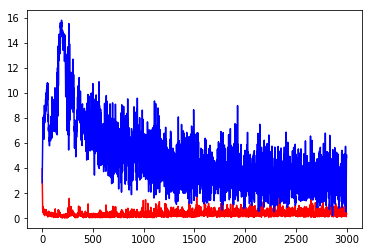

In [8]:
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')

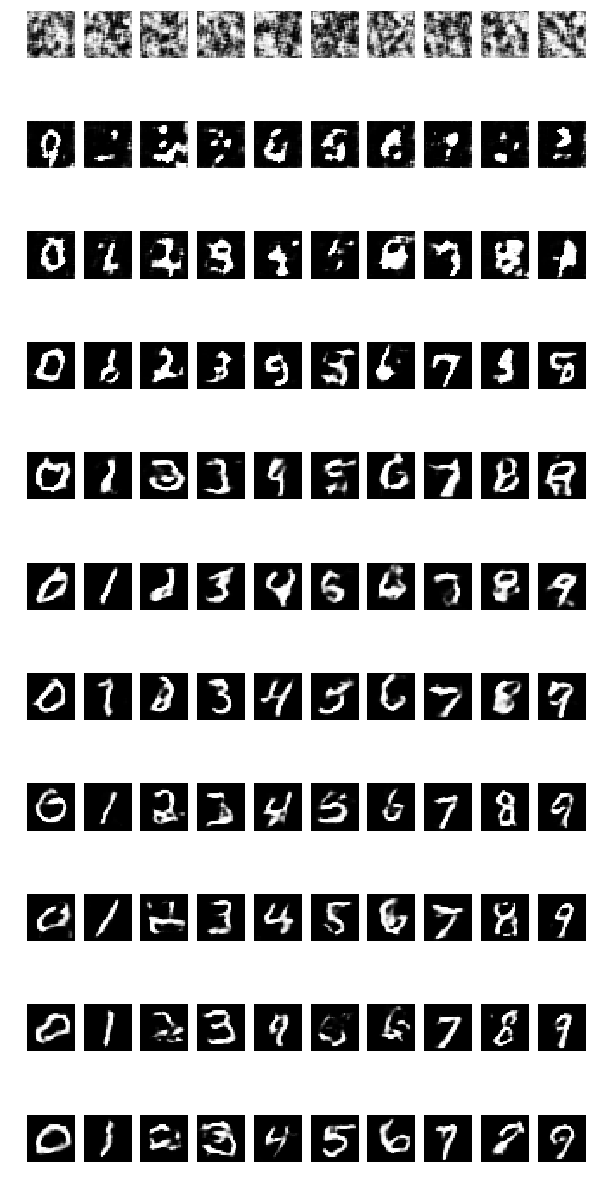

In [9]:
checkpoints = sorted(glob.glob('generator_*.h5'))

plt.figure(figsize=(10,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

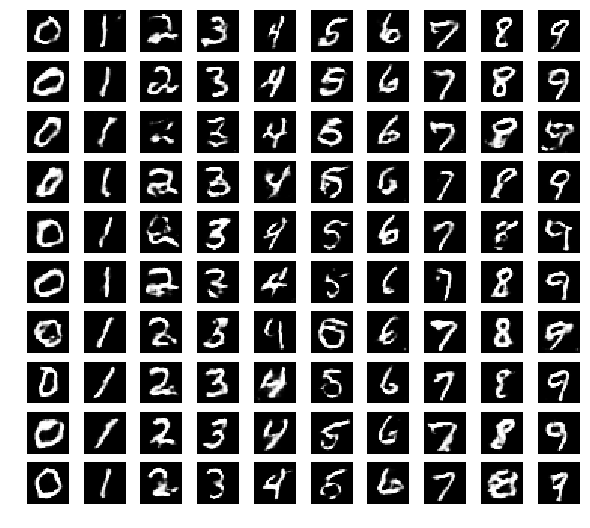

In [10]:
generator.load_weights(checkpoints[-1])
plt.figure(figsize=(10,10))
for i in range(10):
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')